In [1]:
# !git clone -b update-gluonts https://github.com/time-series-foundation-models/lag-llama/
# !pip install -U -r ./lag-llama/requirements.txt 
# !huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir ./lag-llama
# !pip install gluonts==0.14.4

In [2]:
import os 
import sys

In [3]:
sys.path.append("./time-series-models/lag-llama")
sys.path.append("./lag-llama")

In [4]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

import yfinance as yf
import numpy as np
from pprint import pprint 
from datetime import date

In [5]:
import sys
from types import ModuleType

# Create dummy module hierarchy
def create_dummy_module(module_path):
    """
    Create a dummy module hierarchy for the given path.
    Returns the leaf module.
    """
    parts = module_path.split('.')
    current = ''
    parent = None

    for part in parts:
        current = current + '.' + part if current else part
        if current not in sys.modules:
            module = ModuleType(current)
            sys.modules[current] = module
            if parent:
                setattr(sys.modules[parent], part, module)
        parent = current

    return sys.modules[module_path]

# Create the dummy gluonts module hierarchy
gluonts_module = create_dummy_module('gluonts.torch.modules.loss')

# Create dummy classes for the specific loss functions
class DistributionLoss:
    def __init__(self, *args, **kwargs):
        pass

    def __call__(self, *args, **kwargs):
        return 0.0

    def __getattr__(self, name):
        return lambda *args, **kwargs: None

class NegativeLogLikelihood:
    def __init__(self, *args, **kwargs):
        pass

    def __call__(self, *args, **kwargs):
        return 0.0

    def __getattr__(self, name):
        return lambda *args, **kwargs: None

# Add the specific classes to the module
gluonts_module.DistributionLoss = DistributionLoss
gluonts_module.NegativeLogLikelihood = NegativeLogLikelihood

In [6]:
def get_lag_llama_predictions(dataset, prediction_length, device, context_length=32, use_rope_scaling=False, num_samples=100):
    # Use this if we have a GPU:
    # ckpt = torch.load("./time-series-models/lag-llama.ckpt", map_location=device) # Uses GPU since in this Colab we use a GPU.
    
    # Assume we use CPU:
    ckpt = torch.load("./lag-llama.ckpt", map_location=device, weights_only=False)
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path="./lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length, # Lag-Llama was trained with a context length of 32, but can work with any context length

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,

        batch_size=1,
        num_parallel_samples=100,
        device=device,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

In [7]:
url = (
    "https://gist.githubusercontent.com/rsnirwan/a8b424085c9f44ef2598da74ce43e7a3"
    "/raw/b6fdef21fe1f654787fa0493846c546b7f9c4df2/ts_long.csv"
)
df2 = pd.read_csv(url, index_col=0, parse_dates=True)
#df.head()
print(f"Number of target values per item id: {len(df2[df2['item_id'] == 'A'])}")
print(f"List of all unique item_id: {df2['item_id'].unique()}")
print(df2.describe())
print(df2.dtypes)
print(type(df2.index))
display(df2)
df = df2

Number of target values per item id: 240
List of all unique item_id: ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J']
            target
count  2400.000000
mean     -0.000331
std       1.021791
min      -2.629900
25%      -0.586550
50%       0.104150
75%       0.705000
max       2.585700
target     float64
item_id     object
dtype: object
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


,target,item_id
2021-01-01 00:00:00,-1.3378,A
2021-01-01 01:00:00,-1.6111,A
2021-01-01 02:00:00,-1.9259,A
2021-01-01 03:00:00,-1.9184,A
2021-01-01 04:00:00,-1.9168,A
...,...,...
2021-01-10 19:00:00,1.2349,J
2021-01-10 20:00:00,1.1525,J
2021-01-10 21:00:00,1.1485,J
2021-01-10 22:00:00,1.3248,J


In [8]:
# ticker = yf.Ticker("AAPL")
# data_period = "240d"
# 
# # Fetch historical market data
# df = ticker.history(period=data_period)
# df.head()


# We need to propagate the item_id column with {Open, High, Low, Close, Volume}
# Where each item_id will its set of indexed day date, and its associated price
import requests
import pandas as pd
import json

# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=IBM&apikey=demo'
r = requests.get(url)
data = r.json()


# JSON-like dictionary provided by the user

# Extract the "Time Series (Daily)" section
time_series = data["Time Series (Daily)"]

# Convert to DataFrame with the date as the index
df3 = pd.DataFrame.from_dict(time_series, orient='index')

# Rename columns for clarity
df3.rename(columns={
    "1. open": "open",
    "2. high": "high",
    "3. low": "low",
    "4. close": "close",
    "5. volume": "volume"
}, inplace=True)

# Convert data types to appropriate numerical formats
df3 = df3.astype({
    "open": "float",
    "high": "float",
    "low": "float",
    "close": "float",
    "volume": "int"
})

df3 = df3.dropna(subset=['close'])  # Ensure 'close' has no NaNs

df3.index = pd.to_datetime(df3.index, errors='coerce')
df3.sort_index(inplace=True)

df_reset = df3.reset_index().rename(columns={'index': 'date'})
df_melted = df_reset.melt(id_vars=["date"], var_name="item_id", value_name="target")

df_melted['date'] = pd.to_datetime(df_melted['date'], errors='coerce')
df_melted = df_melted.dropna(subset=['date'])
df_melted.set_index("date", inplace=True)

df_melted = df_melted[df_melted['item_id'] == 'close']

df_melted = df_melted[~df_melted.index.duplicated(keep='first')]
df_melted = df_melted.asfreq('B', method='pad')

freq = pd.infer_freq(df_melted.index)
print(f"Frequency inferred: {freq}")
display(df_melted)

Frequency inferred: B


,item_id,target
date,,
2024-09-25,close,221.23
2024-09-26,close,223.43
2024-09-27,close,220.84
2024-09-30,close,221.08
2024-10-01,close,219.35
...,...,...
2025-02-13,close,259.19
2025-02-14,close,261.28
2025-02-17,close,261.28


In [9]:
df = df_melted

In [10]:
# set numerical columns as float32
for col in df.columns:
    # Check if column is not of string type
    if df[col].dtype != 'object' and pd.api.types.is_string_dtype(df[col]) == False:
        df[col] = df[col].astype('float32')

# Create the Pandas
dataset = PandasDataset.from_long_dataframe(df, target="target", item_id="item_id")

backtest_dataset = dataset
# prediction_length = 24  # Define your prediction length. We use 24 here since the data is of hourly frequency

prediction_length = 24 # We predict just the next day?

num_samples = 350 # number of samples sampled from the probability distribution for each timestep
# device = torch.device("cuda:0") # You can switch this to CPU or other GPUs if you'd like, depending on your environment

# Lets go CPU
device = torch.device("cpu") 

In [11]:
# Zero shot inference
forecasts, tss = get_lag_llama_predictions(backtest_dataset, prediction_length, device, num_samples)

# We could go in 

/Users/lajiet/anaconda3/lib/python3.11/site-packages/gluonts/dataset/pandas.py:174: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  df = df.to_period(freq=self.freq)
/Users/lajiet/anaconda3/lib/python3.11/site-packages/gluonts/dataset/split.py:181: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  sliced_entry[FieldName.START] += offset
/Users/lajiet/anaconda3/lib/python3.11/site-packages/gluonts/transform/feature.py:364: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  index = pd.period_range(start, periods=length, freq=start.freq)
/Users/lajiet/anaconda3/lib/python3.11/site-packages/gluonts/transform/feature.py:364: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='

In [12]:
print(len(forecasts))

print(forecasts[0])

1
gluonts.model.forecast.SampleForecast(info=None, item_id='close', samples=array([[ 73.30707 , 123.22991 , 188.62161 , ..., 234.51706 , 228.43953 ,
        119.583145],
       [115.631134, 231.6977  , 199.95563 , ..., 225.6812  , 212.02869 ,
        227.39175 ],
       [263.82138 , 230.07298 , 185.01678 , ..., 141.73596 , 268.42908 ,
        254.21024 ],
       ...,
       [352.62317 , 352.20013 , 257.8499  , ..., 176.01814 , 250.00754 ,
        195.36343 ],
       [105.991165, 139.5758  , 169.38564 , ..., 171.39334 , 229.86812 ,
        160.74481 ],
       [130.64954 , 233.2165  , 282.56165 , ...,  83.13417 , 221.03752 ,
        288.85635 ]], dtype=float32), start_date=Period('2025-01-17', 'B'))


In [13]:
forecasts[0].samples.shape

(100, 24)

/var/folders/75/q92ms1g96zg7cy3q5zmjh2100000gn/T/ipykernel_37072/3725362289.py:9: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
/Users/lajiet/anaconda3/lib/python3.11/site-packages/gluonts/model/forecast.py:365: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  self._index = pd.period_range(
/Users/lajiet/anaconda3/lib/python3.11/site-packages/gluonts/model/forecast.py:365: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  self._index = pd.period_range(
/Users/lajiet/anaconda3/lib/python3.11/site-packages/gluonts/model/forecast.py:328: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  self.ind

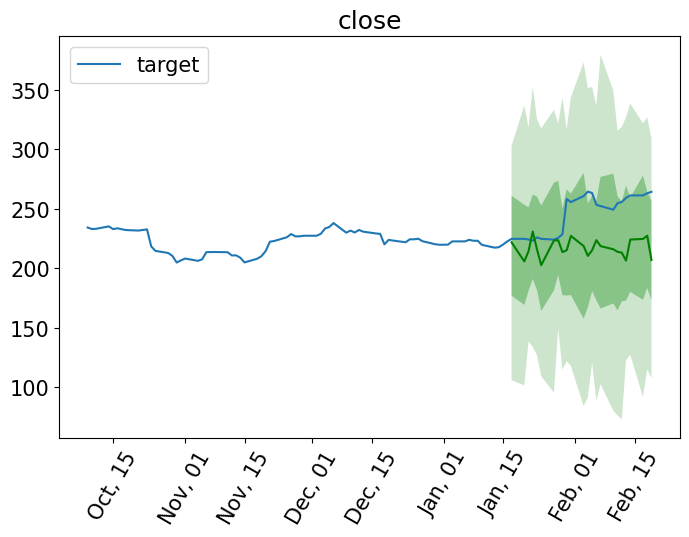

In [14]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [15]:
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    print(forecast.item_id)
    # What is 100? (the model sample 100 samples from the predictive distribution) Might need to fit a KDE
    # What is 24?: (next 24 hours), for us if we use days, we might want to set to 1 day
    print(forecast.samples.shape) 
    print(forecast.samples)

close
(100, 24)
[[ 73.30707  123.22991  188.62161  ... 234.51706  228.43953  119.583145]
 [115.631134 231.6977   199.95563  ... 225.6812   212.02869  227.39175 ]
 [263.82138  230.07298  185.01678  ... 141.73596  268.42908  254.21024 ]
 ...
 [352.62317  352.20013  257.8499   ... 176.01814  250.00754  195.36343 ]
 [105.991165 139.5758   169.38564  ... 171.39334  229.86812  160.74481 ]
 [130.64954  233.2165   282.56165  ...  83.13417  221.03752  288.85635 ]]


In [ ]:
# Still testing ... 